In [1]:
pip install torch


Note: you may need to restart the kernel to use updated packages.


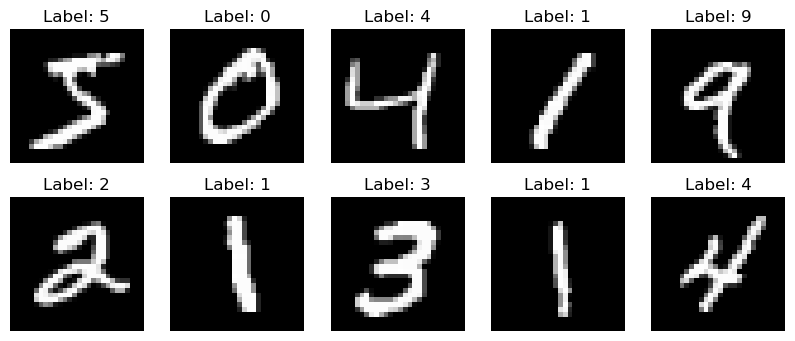

In [19]:
import torch
import numpy as np
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
import matplotlib.ticker as ticker

# Check if mps is available
#device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
# Load the MNIST dataset
mnist = fetch_openml('mnist_784', version=1, cache=True, as_frame=False)
# Convert data and target to numpy arrays
data = mnist.data
target = mnist.target.astype(np.uint8)  # convert labels from string to integer

# Split into training and testing sets
train_imgs = data[:60000]
train_labels = target[:60000]
test_imgs = data[60000:]
test_labels = target[60000:]

# Visualize the first 10 images and labels
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i, ax in enumerate(axes.flat):
    ax.imshow(train_imgs[i].reshape(28, 28), cmap='gray')
    ax.set_title("Label: {}".format(train_labels[i]))  # Use slicing train_labels[:10] to get first 10 labels
    ax.axis('off')

plt.show()

# Convert numpy arrays to PyTorch tensors
train_imgs = torch.from_numpy(train_imgs).float()
train_labels = torch.from_numpy(train_labels)
test_imgs = torch.from_numpy(test_imgs).float()
test_labels = torch.from_numpy(test_labels)

# Normalize the images to [-1, 1]
train_imgs = train_imgs / 255. * 2 - 1
test_imgs = test_imgs / 255. * 2 - 1


# Create data loaders
train_dataset = TensorDataset(train_imgs, train_labels)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

test_dataset = TensorDataset(test_imgs, test_labels)
test_loader = DataLoader(test_dataset, batch_size=1)



Training with learning rate: 0.0001
Epoch 1, Accuracy: 89.06%
Epoch 2, Accuracy: 90.72%
Epoch 3, Accuracy: 91.39%
Epoch 4, Accuracy: 91.84%
Epoch 5, Accuracy: 91.86%
Epoch 6, Accuracy: 92.91%
Epoch 7, Accuracy: 93.15%
Epoch 8, Accuracy: 93.45%
Epoch 9, Accuracy: 93.69%
Epoch 10, Accuracy: 93.85%
Epoch 11, Accuracy: 93.96%
Epoch 12, Accuracy: 94.07%
Epoch 13, Accuracy: 94.37%
Epoch 14, Accuracy: 94.63%
Epoch 15, Accuracy: 94.79%
Epoch 16, Accuracy: 94.86%
Epoch 17, Accuracy: 94.97%
Epoch 18, Accuracy: 95.16%
Stopping training after reaching 95.16% accuracy.
Training with learning rate: 0.001
Epoch 1, Accuracy: 92.41%
Epoch 2, Accuracy: 94.86%
Epoch 3, Accuracy: 95.95%
Stopping training after reaching 95.95% accuracy.
Training with learning rate: 0.01
Epoch 1, Accuracy: 93.15%
Epoch 2, Accuracy: 93.15%
Epoch 3, Accuracy: 93.18%
Epoch 4, Accuracy: 95.28%
Stopping training after reaching 95.28% accuracy.
Training with learning rate: 0.05
Epoch 1, Accuracy: 87.32%
Epoch 2, Accuracy: 90.72%


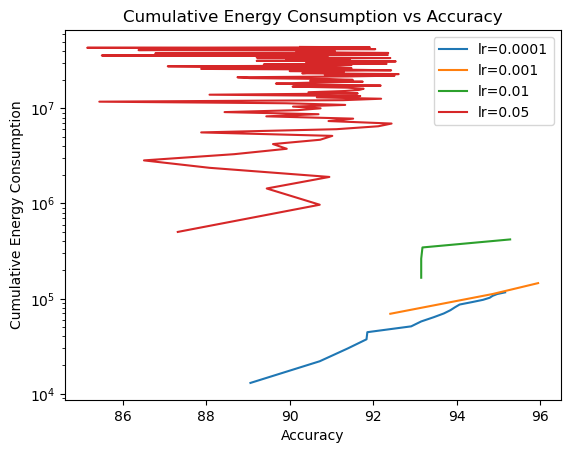

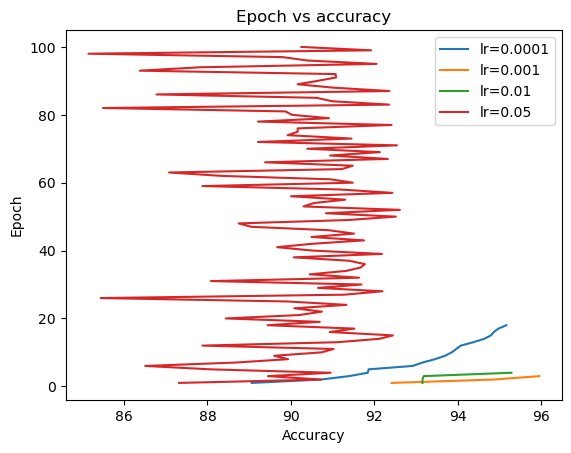

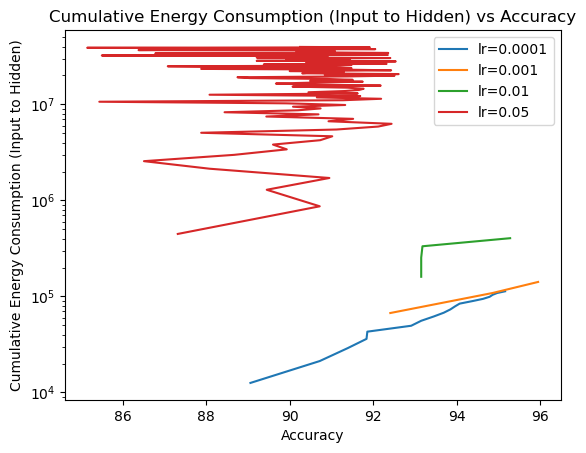

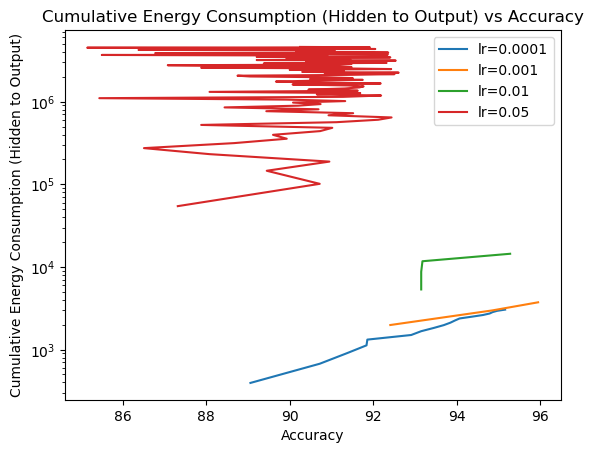

In [20]:
class FFNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FFNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)

        # Xavier initialization
        nn.init.xavier_normal_(self.fc1.weight)
        nn.init.xavier_normal_(self.fc2.weight)

    def forward(self, x):
        x = self.leaky_relu(self.fc1(x))
        x = self.fc2(x)
        return x


# Instantiate the network
input_dim = 784  # MNIST images are 28x28
hidden_dim = 100
output_dim = 10  # 10 classes

learning_rates = [0.0001, 0.001, 0.01, 0.05]
for lr in learning_rates:
    print(f'Training with learning rate: {lr}')
    model = FFNN(input_dim, hidden_dim, output_dim)
    # Move the model to GPU if available
    #model.to(device)
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    # Training
    epochs = 100
    best_accuracy = 0
    epochs_without_improvement = 0
    accuracies = []
    cumulative_energy_consumption = 0
    energy_consumptions = []
    cumulative_energy_consumption_input_to_hidden = 0
    cumulative_energy_consumption_hidden_to_output = 0
    energy_consumptions_input_to_hidden = []
    energy_consumptions_hidden_to_output = []
    for epoch in range(epochs):
        energy_consumption = 0
        energy_consumption_input_to_hidden = 0 
        energy_consumption_hidden_to_output = 0 
        for images, labels in train_loader:
            # Move images and labels to GPU if available
            #images = images.to(device)
            #labels = labels.to(device)
            # Clear gradients
            optimizer.zero_grad()
            # Forward propagation
            outputs = model(images)
            # Calculate loss
            loss = criterion(outputs, labels)
            # Backpropagation
            loss.backward()
            # Save the current weights
            weights_before_update = [w.clone() for w in model.parameters()]
            # Update weights
            optimizer.step()
            # Calculate the size of the weight updates using L1 norm
            weight_updates = [weights_before_update[i] - w for i, w in enumerate(model.parameters())]
            weight_update_sizes = [w.abs().sum().item() for w in weight_updates]  # L1 norm
    
            # Estimate the energy consumption as the sum of the weight update sizes
            energy_consumption += sum(weight_update_sizes)
            energy_consumption_input_to_hidden += weight_updates[0].abs().sum().item() + weight_updates[1].abs().sum().item()  # L1 norm for input to hidden
            energy_consumption_hidden_to_output += weight_updates[2].abs().sum().item() + weight_updates[3].abs().sum().item()  # L1 norm for hidden to output

        cumulative_energy_consumption += energy_consumption
        cumulative_energy_consumption_input_to_hidden += energy_consumption_input_to_hidden
        cumulative_energy_consumption_hidden_to_output += energy_consumption_hidden_to_output
        energy_consumptions.append(cumulative_energy_consumption)
        energy_consumptions_input_to_hidden.append(cumulative_energy_consumption_input_to_hidden)
        energy_consumptions_hidden_to_output.append(cumulative_energy_consumption_hidden_to_output)

        # Test
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                #images = images.to(device)
                #labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        accuracies.append(accuracy)
        print(f'Epoch {epoch+1}, Accuracy: {accuracy}%')

        # Stop training if accuracy reaches 95%
        if accuracy >= 95:
            print(f'Stopping training after reaching {accuracy}% accuracy.')
            break
    
    plt.figure(1) 
    plt.semilogy(accuracies, energy_consumptions, label=f'lr={lr}')
    plt.xlabel('Accuracy')
    plt.ylabel('Cumulative Energy Consumption')
    plt.title('Cumulative Energy Consumption vs Accuracy')
    plt.legend()
    plt.figure(2)  
    plt.plot(accuracies, range(1, len(accuracies) + 1), label=f'lr={lr}')
    plt.xlabel('Accuracy')
    plt.ylabel('Epoch')
    plt.title('Epoch vs accuracy')
    plt.legend()
    plt.figure(3)
    plt.semilogy(accuracies, energy_consumptions_input_to_hidden, label=f'lr={lr}')
    plt.xlabel('Accuracy')
    plt.ylabel('Cumulative Energy Consumption (Input to Hidden)')
    plt.title('Cumulative Energy Consumption (Input to Hidden) vs Accuracy')
    plt.legend()
    plt.figure(4)
    plt.semilogy(accuracies, energy_consumptions_hidden_to_output, label=f'lr={lr}')
    plt.xlabel('Accuracy')
    plt.ylabel('Cumulative Energy Consumption (Hidden to Output)')
    plt.title('Cumulative Energy Consumption (Hidden to Output) vs Accuracy')
    plt.legend()

plt.figure(1)
plt.savefig("/Users/tim/Desktop/postgraduate/research project/STUDY/diagram/learningrate_energy_vs_accuracy.png")

plt.figure(2)
plt.savefig("/Users/tim/Desktop/postgraduate/research project/STUDY/diagram/learningrate_epochs_vs_accuracy.png")


plt.figure(3)
plt.savefig("/Users/tim/Desktop/postgraduate/research project/STUDY/diagram/input_to_hidden.png")


plt.figure(4)
plt.savefig("/Users/tim/Desktop/postgraduate/research project/STUDY/diagram/hidden_to_output.png")
plt.show()


Training with hidden_dim=100, num_layers=1
Epoch 1, Accuracy: 88.67%
Epoch 2, Accuracy: 90.5%
Epoch 3, Accuracy: 91.26%
Epoch 4, Accuracy: 91.83%
Epoch 5, Accuracy: 92.25%
Epoch 6, Accuracy: 92.56%
Epoch 7, Accuracy: 93.03%
Epoch 8, Accuracy: 93.29%
Epoch 9, Accuracy: 93.4%
Epoch 10, Accuracy: 93.78%
Epoch 11, Accuracy: 94.07%
Epoch 12, Accuracy: 94.38%
Epoch 13, Accuracy: 94.62%
Epoch 14, Accuracy: 94.69%
Epoch 15, Accuracy: 94.9%
Epoch 16, Accuracy: 94.98%
Epoch 17, Accuracy: 95.08%
Stopping training after reaching 95.08% accuracy.
Training with hidden_dim=1000, num_layers=1
Epoch 1, Accuracy: 90.36%
Epoch 2, Accuracy: 91.66%
Epoch 3, Accuracy: 92.54%
Epoch 4, Accuracy: 93.22%
Epoch 5, Accuracy: 93.35%
Epoch 6, Accuracy: 93.61%
Epoch 7, Accuracy: 94.17%
Epoch 8, Accuracy: 94.14%
Epoch 9, Accuracy: 94.58%
Epoch 10, Accuracy: 94.91%
Epoch 11, Accuracy: 95.02%
Stopping training after reaching 95.02% accuracy.
Training with hidden_dim=10000, num_layers=1
Epoch 1, Accuracy: 90.87%
Epoch 2

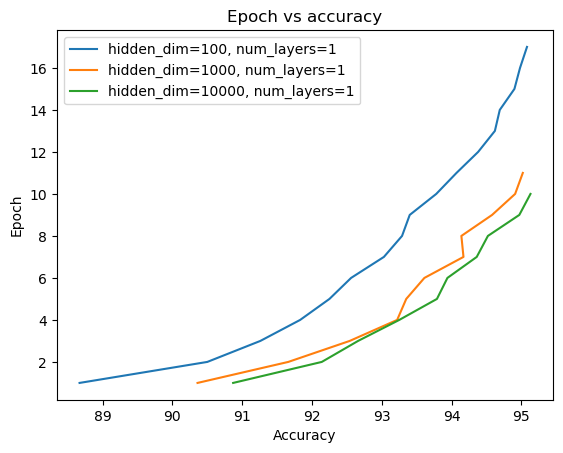

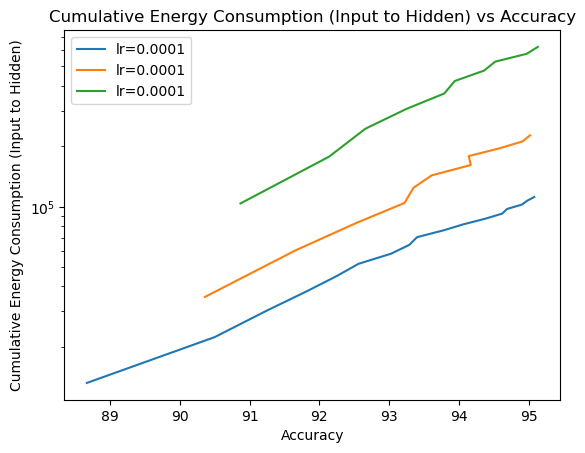

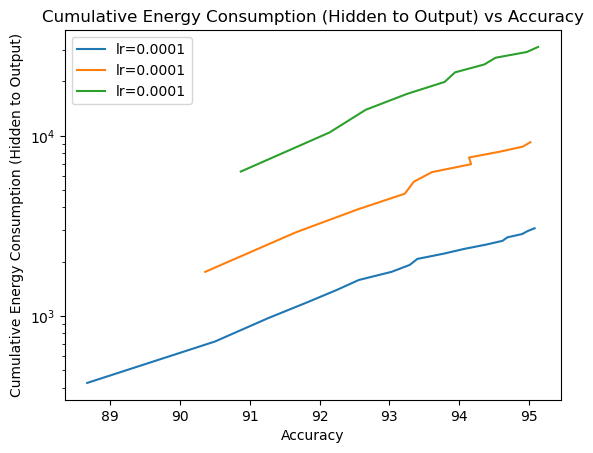

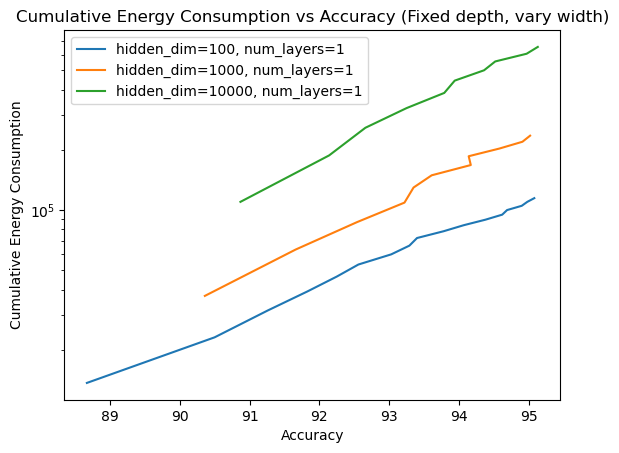

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

Elapsed time: 9982.290282726288 seconds


In [7]:
import time
# Check if mps is available
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
class FFNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(FFNN, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_dim, hidden_dim))  # input layer
        nn.init.xavier_normal_(self.layers[-1].weight)  # Xavier initialization for input layer

        for _ in range(num_layers - 1):  # hidden layers
            self.layers.append(nn.Linear(hidden_dim, hidden_dim))
            nn.init.xavier_normal_(self.layers[-1].weight)  # Xavier initialization for hidden layers

        self.layers.append(nn.Linear(hidden_dim, output_dim))  # output layer
        nn.init.xavier_normal_(self.layers[-1].weight)  # Xavier initialization for output layer

        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)

    def forward(self, x):
        for layer in self.layers[:-1]:  # all layers except last one
            x = self.leaky_relu(layer(x))
        x = self.layers[-1](x)  # last layer without activation
        return x



# Instantiate the network
input_dim = 784  # MNIST images are 28x28
hidden_dim = 100
output_dim = 10  # 10 classes
    
# Check if mps is available
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# Define the structure variations
width_variations = [100, 1000, 10000]
lr=0.0001

start_time = time.time()

# Fixed depth, vary width
for hidden_dim in width_variations:
    print(f'Training with hidden_dim={hidden_dim}, num_layers=1')

    # Instantiate the network with the specified structure
    model = FFNN(input_dim, hidden_dim, output_dim, 1)
    # Move the model to GPU if available
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    # Training
    epochs = 100
    best_accuracy = 0
    epochs_without_improvement = 0
    accuracies = []
    cumulative_energy_consumption = 0
    energy_consumptions = []
    cumulative_energy_consumption_input_to_hidden = 0
    cumulative_energy_consumption_hidden_to_output = 0
    energy_consumptions_input_to_hidden = []
    energy_consumptions_hidden_to_output = []
    epochs_list = [] 
    for epoch in range(epochs):
        energy_consumption = 0
        energy_consumption_input_to_hidden = 0 
        energy_consumption_hidden_to_output = 0 
        for images, labels in train_loader:
            # Move images and labels to GPU if available
            images = images.to(device)
            labels = labels.to(device)
            # Clear gradients
            optimizer.zero_grad()
            # Forward propagation
            outputs = model(images)
            # Calculate loss
            loss = criterion(outputs, labels)
            # Backpropagation
            loss.backward()
            # Save the current weights
            weights_before_update = [w.clone() for w in model.parameters()]
            # Update weights
            optimizer.step()
            # Calculate the size of the weight updates using L1 norm
            weight_updates = [weights_before_update[i] - w for i, w in enumerate(model.parameters())]
            weight_update_sizes = [w.abs().sum().item() for w in weight_updates]  # L1 norm
            # Estimate the energy consumption as the sum of the weight update sizes
            energy_consumption += sum(weight_update_sizes)
            energy_consumption_input_to_hidden += weight_updates[0].abs().sum().item() + weight_updates[1].abs().sum().item()  # L1 norm for input to hidden
            energy_consumption_hidden_to_output += weight_updates[2].abs().sum().item() + weight_updates[3].abs().sum().item()  # L1 norm for hidden to output

        cumulative_energy_consumption += energy_consumption
        cumulative_energy_consumption_input_to_hidden += energy_consumption_input_to_hidden
        cumulative_energy_consumption_hidden_to_output += energy_consumption_hidden_to_output
        energy_consumptions.append(cumulative_energy_consumption)
        energy_consumptions_input_to_hidden.append(cumulative_energy_consumption_input_to_hidden)
        energy_consumptions_hidden_to_output.append(cumulative_energy_consumption_hidden_to_output)


        # Test
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        accuracies.append(accuracy)
        print(f'Epoch {epoch+1}, Accuracy: {accuracy}%')

        # Stop training if accuracy reaches 95%
        if accuracy >= 95:
            print(f'Stopping training after reaching {accuracy}% accuracy.')
            break
            
    plt.figure(1)        
    plt.semilogy(accuracies, energy_consumptions, label=f'hidden_dim={hidden_dim}, num_layers=1')
    plt.xlabel('Accuracy')
    plt.ylabel('Cumulative Energy Consumption')
    plt.title('Cumulative Energy Consumption vs Accuracy (Fixed depth, vary width)')
    plt.legend()
    plt.figure(2)  
    plt.plot(accuracies, range(1, len(accuracies) + 1), label=f'hidden_dim={hidden_dim}, num_layers=1')
    plt.xlabel('Accuracy')
    plt.ylabel('Epoch')
    plt.title('Epoch vs accuracy')
    plt.legend()
    plt.figure(3)
    plt.semilogy(accuracies, energy_consumptions_input_to_hidden, label=f'lr={lr}')
    plt.xlabel('Accuracy')
    plt.ylabel('Cumulative Energy Consumption (Input to Hidden)')
    plt.title('Cumulative Energy Consumption (Input to Hidden) vs Accuracy')
    plt.legend()
    plt.figure(4)
    plt.semilogy(accuracies, energy_consumptions_hidden_to_output, label=f'lr={lr}')
    plt.xlabel('Accuracy')
    plt.ylabel('Cumulative Energy Consumption (Hidden to Output)')
    plt.title('Cumulative Energy Consumption (Hidden to Output) vs Accuracy')
    plt.legend()



plt.figure(1)
plt.savefig("/Users/tim/Desktop/postgraduate/research project/STUDY/diagram/varywidth_energy_vs_accuracy.png")


plt.figure(2)
plt.savefig("/Users/tim/Desktop/postgraduate/research project/STUDY/diagram/varywidthaccuracy_over_epochs.png")

plt.figure(3)
plt.savefig("/Users/tim/Desktop/postgraduate/research project/STUDY/diagram/varywidthinput_to_hidden.png")


plt.figure(4)
plt.savefig("/Users/tim/Desktop/postgraduate/research project/STUDY/diagram/varywidthhidden_to_output.png")
plt.show()



end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")


Training with hidden_dim=100, num_layers=1
Epoch 1, Accuracy: 88.0%
Epoch 2, Accuracy: 89.94%
Epoch 3, Accuracy: 90.53%
Epoch 4, Accuracy: 91.42%
Epoch 5, Accuracy: 91.96%
Epoch 6, Accuracy: 92.26%
Epoch 7, Accuracy: 92.56%
Epoch 8, Accuracy: 92.93%
Epoch 9, Accuracy: 93.24%
Epoch 10, Accuracy: 93.35%
Epoch 11, Accuracy: 93.93%
Epoch 12, Accuracy: 93.96%
Epoch 13, Accuracy: 94.11%
Epoch 14, Accuracy: 94.12%
Epoch 15, Accuracy: 94.51%
Epoch 16, Accuracy: 94.65%
Epoch 17, Accuracy: 94.74%
Epoch 18, Accuracy: 94.82%
Epoch 19, Accuracy: 95.1%
Stopping training after reaching 95.1% accuracy.
Training with hidden_dim=100, num_layers=3
Epoch 1, Accuracy: 76.14%
Epoch 2, Accuracy: 87.18%
Epoch 3, Accuracy: 89.41%
Epoch 4, Accuracy: 90.53%
Epoch 5, Accuracy: 91.28%
Epoch 6, Accuracy: 92.0%
Epoch 7, Accuracy: 92.12%
Epoch 8, Accuracy: 92.59%
Epoch 9, Accuracy: 93.55%
Epoch 10, Accuracy: 93.71%
Epoch 11, Accuracy: 93.96%
Epoch 12, Accuracy: 94.33%
Epoch 13, Accuracy: 94.74%
Epoch 14, Accuracy: 94

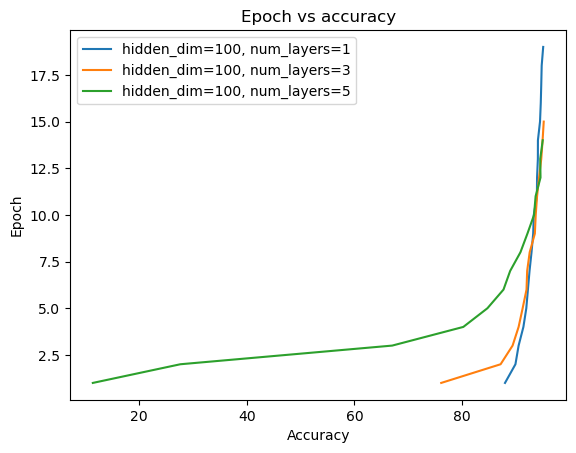

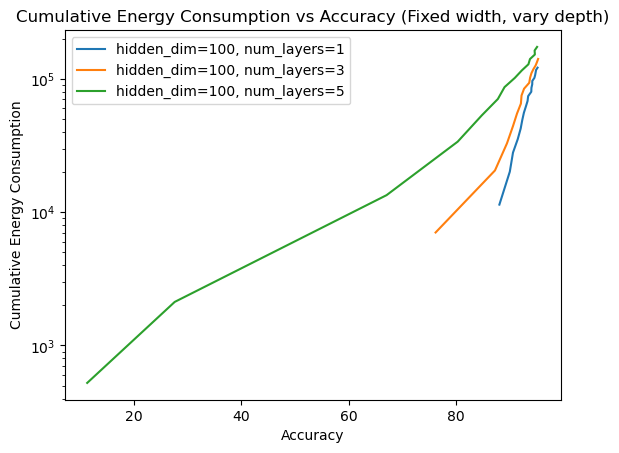

<Figure size 640x480 with 0 Axes>

Elapsed time: 11836.705127239227 seconds


In [15]:
import time
class FFNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(FFNN, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_dim, hidden_dim))  # input layer
        for _ in range(num_layers - 1):  # hidden layers
            self.layers.append(nn.Linear(hidden_dim, hidden_dim))
        self.layers.append(nn.Linear(hidden_dim, output_dim))  # output layer
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)

    def forward(self, x):
        for layer in self.layers[:-1]:  # all layers except last one
            x = self.leaky_relu(layer(x))
        x = self.layers[-1](x)  # last layer without activation
        return x
# Instantiate the network
input_dim = 784  # MNIST images are 28x28
hidden_dim = 100
output_dim = 10  # 10 classes

# Check if mps is available
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

depth_variations = [1, 3, 5]
lr=0.0001
start_time = time.time()
# Fixed width, vary depth
for num_layers in depth_variations:
    print(f'Training with hidden_dim=100, num_layers={num_layers}')

    # Instantiate the network with the specified structure
    model = FFNN(input_dim, 100, output_dim, num_layers)
    # Move the model to GPU if available
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    # Training
    epochs = 100
    best_accuracy = 0
    epochs_without_improvement = 0
    accuracies = []
    cumulative_energy_consumption = 0
    energy_consumptions = []
    
    for epoch in range(epochs):
        energy_consumption = 0
        for images, labels in train_loader:
            # Move images and labels to GPU if available
            images = images.to(device)
            labels = labels.to(device)
            # Clear gradients
            optimizer.zero_grad()
            # Forward propagation
            outputs = model(images)
            # Calculate loss
            loss = criterion(outputs, labels)
            # Backpropagation
            loss.backward()
            # Save the current weights
            weights_before_update = [w.clone() for w in model.parameters()]
            # Update weights
            optimizer.step()
            # Calculate the size of the weight updates using L1 norm
            weight_updates = [weights_before_update[i] - w for i, w in enumerate(model.parameters())]
            weight_update_sizes = [w.abs().sum().item() for w in weight_updates]  # L1 norm
            # Estimate the energy consumption as the sum of the weight update sizes
            energy_consumption += sum(weight_update_sizes)
        cumulative_energy_consumption += energy_consumption
        energy_consumptions.append(cumulative_energy_consumption)

        # Test
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        accuracies.append(accuracy)
        print(f'Epoch {epoch+1}, Accuracy: {accuracy}%')

        # Stop training if accuracy reaches 95%
        if accuracy >= 95:
            print(f'Stopping training after reaching {accuracy}% accuracy.')
            break

    plt.figure(1)
    plt.semilogy(accuracies, energy_consumptions, label=f'hidden_dim=100, num_layers={num_layers}')
    plt.xlabel('Accuracy')
    plt.ylabel('Cumulative Energy Consumption')
    plt.title('Cumulative Energy Consumption vs Accuracy (Fixed width, vary depth)')
    plt.legend()
    plt.figure(2)
    plt.plot(accuracies, range(1, len(accuracies) + 1), label=f'hidden_dim=100, num_layers={num_layers}')
    plt.xlabel('Accuracy')
    plt.ylabel('Epoch')
    plt.title('Epoch vs accuracy')
    plt.legend()

plt.figure(1)
plt.savefig("/Users/tim/Desktop/postgraduate/research project/STUDY/diagram/varydepth_energy_vs_accuracy.png")


plt.figure(2)
plt.savefig("/Users/tim/Desktop/postgraduate/research project/STUDY/diagram/varydepthaccuracy_over_epochs.png")
plt.show()



end_time = time.time()

elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")



Training with hidden_dim=100, num_layers=1
Epoch 1, Accuracy: 88.19%
Epoch 2, Accuracy: 90.15%
Epoch 3, Accuracy: 90.83%
Epoch 4, Accuracy: 91.32%
Epoch 5, Accuracy: 91.61%
Epoch 6, Accuracy: 91.83%
Epoch 7, Accuracy: 92.28%
Epoch 8, Accuracy: 92.6%
Epoch 9, Accuracy: 92.84%
Epoch 10, Accuracy: 93.24%
Epoch 11, Accuracy: 93.55%
Epoch 12, Accuracy: 93.75%
Epoch 13, Accuracy: 93.86%
Epoch 14, Accuracy: 94.04%
Epoch 15, Accuracy: 94.28%
Epoch 16, Accuracy: 94.34%
Epoch 17, Accuracy: 94.45%
Epoch 18, Accuracy: 94.55%
Epoch 19, Accuracy: 94.96%
Epoch 20, Accuracy: 95.01%
Stopping training after reaching 95.01% accuracy.
Training with hidden_dim=200, num_layers=1
Epoch 1, Accuracy: 88.11%
Epoch 2, Accuracy: 89.8%
Epoch 3, Accuracy: 90.78%
Epoch 4, Accuracy: 91.46%
Epoch 5, Accuracy: 91.68%
Epoch 6, Accuracy: 92.11%
Epoch 7, Accuracy: 92.29%
Epoch 8, Accuracy: 92.78%
Epoch 9, Accuracy: 93.16%
Epoch 10, Accuracy: 93.35%
Epoch 11, Accuracy: 93.48%
Epoch 12, Accuracy: 93.76%
Epoch 13, Accuracy: 

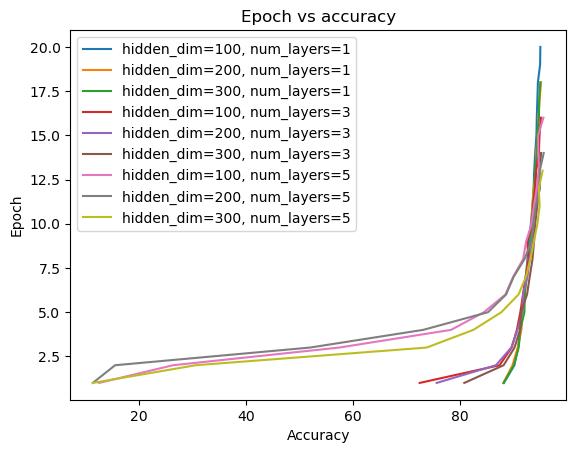

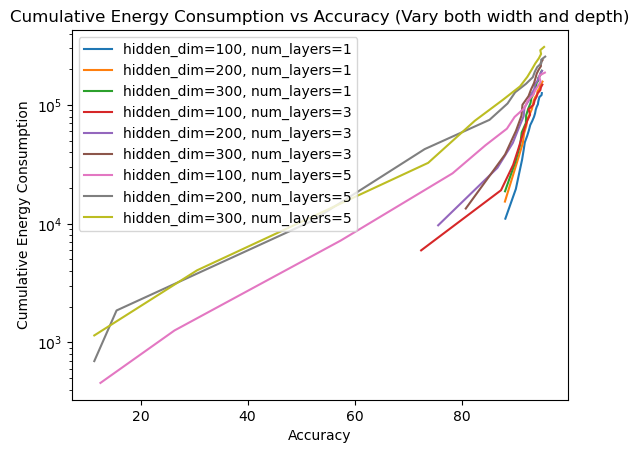

<Figure size 640x480 with 0 Axes>

In [16]:
class FFNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(FFNN, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_dim, hidden_dim))  # input layer
        for _ in range(num_layers - 1):  # hidden layers
            self.layers.append(nn.Linear(hidden_dim, hidden_dim))
        self.layers.append(nn.Linear(hidden_dim, output_dim))  # output layer
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)

    def forward(self, x):
        for layer in self.layers[:-1]:  # all layers except last one
            x = self.leaky_relu(layer(x))
        x = self.layers[-1](x)  # last layer without activation
        return x

# Instantiate the network
input_dim = 784  # MNIST images are 28x28
hidden_dim = 100
output_dim = 10  # 10 classes

structure_variations = [(100, 1), (200, 1), (300, 1), (100, 3), (200, 3), (300, 3), (100, 5), (200, 5), (300, 5)]
lr=0.0001

# Vary both width and depth
for hidden_dim, num_layers in structure_variations:
    print(f'Training with hidden_dim={hidden_dim}, num_layers={num_layers}')

    # Instantiate the network with the specified structure
    model = FFNN(input_dim, hidden_dim, output_dim, num_layers)
    # Move the model to GPU if available
    #model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    # Training
    epochs = 100
    best_accuracy = 0
    epochs_without_improvement = 0
    accuracies = []
    cumulative_energy_consumption = 0
    energy_consumptions = []
   
    for epoch in range(epochs):
        energy_consumption = 0
        for images, labels in train_loader:
            # Move images and labels to GPU if available
            #images = images.to(device)
            #labels = labels.to(device)
            # Clear gradients
            optimizer.zero_grad()
            # Forward propagation
            outputs = model(images)
            # Calculate loss
            loss = criterion(outputs, labels)
            # Backpropagation
            loss.backward()
            # Save the current weights
            weights_before_update = [w.clone() for w in model.parameters()]
            # Update weights
            optimizer.step()
            # Calculate the size of the weight updates using L1 norm
            weight_updates = [weights_before_update[i] - w for i, w in enumerate(model.parameters())]
            weight_update_sizes = [w.abs().sum().item() for w in weight_updates]  # L1 norm
            # Estimate the energy consumption as the sum of the weight update sizes
            energy_consumption += sum(weight_update_sizes)
        cumulative_energy_consumption += energy_consumption
        energy_consumptions.append(cumulative_energy_consumption)
        
        
        # Test
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                #images = images.to(device)
                #labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        accuracies.append(accuracy)
        print(f'Epoch {epoch+1}, Accuracy: {accuracy}%')

        # Stop training if accuracy reaches 95%
        if accuracy >= 95:
            print(f'Stopping training after reaching {accuracy}% accuracy.')
            break
    
    plt.figure(1)     
    plt.semilogy(accuracies, energy_consumptions, label=f'hidden_dim={hidden_dim}, num_layers={num_layers}')
    plt.xlabel('Accuracy')
    plt.ylabel('Cumulative Energy Consumption')
    plt.title('Cumulative Energy Consumption vs Accuracy (Vary both width and depth)')
    plt.legend()
    plt.figure(2)
    plt.plot(accuracies, range(1, len(accuracies) + 1), label=f'hidden_dim={hidden_dim}, num_layers={num_layers}')
    plt.xlabel('Accuracy')
    plt.ylabel('Epoch')
    plt.title('Epoch vs accuracy')
    plt.legend()

    

plt.figure(1)
plt.savefig("/Users/tim/Desktop/postgraduate/research project/STUDY/diagram/varydepthandwidth_energy_vs_accuracy.png")
plt.show()

plt.figure(2)
plt.savefig("/Users/tim/Desktop/postgraduate/research project/STUDY/diagram/varydepthandwidthaccuracy_over_epochs.png")
plt.show()


Training with num_blocks=[1, 1, 1, 1]
Epoch 1, Accuracy: 48.05%
Epoch 2, Accuracy: 64.33%
Epoch 3, Accuracy: 72.19%
Epoch 4, Accuracy: 77.19%
Epoch 5, Accuracy: 80.58%
Epoch 6, Accuracy: 82.7%
Epoch 7, Accuracy: 84.39%
Epoch 8, Accuracy: 86.01%
Epoch 9, Accuracy: 87.16%
Epoch 10, Accuracy: 88.2%
Epoch 11, Accuracy: 89.01%
Epoch 12, Accuracy: 89.92%
Epoch 13, Accuracy: 90.57%
Epoch 14, Accuracy: 91.12%
Epoch 15, Accuracy: 91.63%
Epoch 16, Accuracy: 92.1%
Epoch 17, Accuracy: 92.58%
Epoch 18, Accuracy: 92.95%
Epoch 19, Accuracy: 93.29%
Epoch 20, Accuracy: 93.54%
Epoch 21, Accuracy: 93.77%
Epoch 22, Accuracy: 94.03%
Epoch 23, Accuracy: 94.25%
Epoch 24, Accuracy: 94.47%
Epoch 25, Accuracy: 94.64%
Epoch 26, Accuracy: 94.81%
Epoch 27, Accuracy: 94.92%
Epoch 28, Accuracy: 95.13%
Stopping training after reaching 95.13% accuracy.
Training with num_blocks=[2, 2, 2, 2]
Epoch 1, Accuracy: 58.24%
Epoch 2, Accuracy: 76.02%
Epoch 3, Accuracy: 82.57%
Epoch 4, Accuracy: 86.28%
Epoch 5, Accuracy: 88.69%


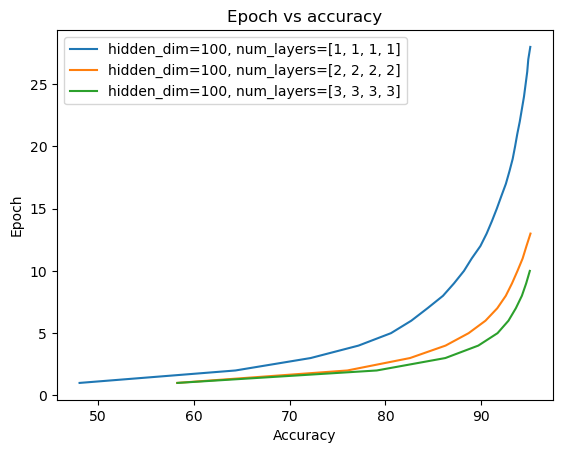

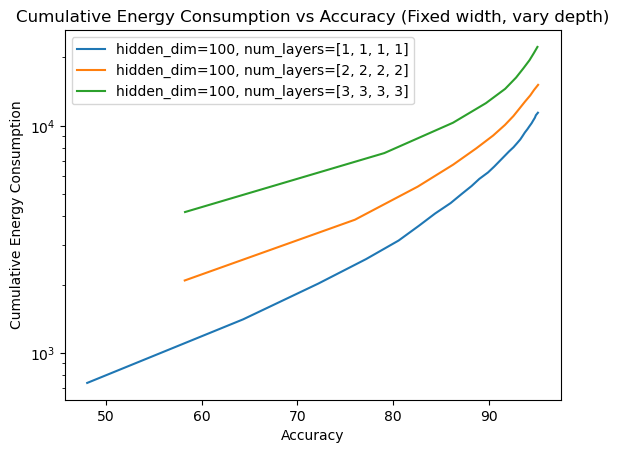

<Figure size 640x480 with 0 Axes>

Elapsed time: 3915.0211629867554 seconds


In [12]:
import torch.nn.functional as F
import torch.nn as nn
import torch
import time

class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Identity shortcut connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

        # Xavier initialization
        nn.init.xavier_uniform_(self.conv1.weight)
        nn.init.xavier_uniform_(self.conv2.weight)
        if stride != 1 or in_channels != out_channels:
            nn.init.xavier_uniform_(self.shortcut[0].weight)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512, num_classes)

        # Xavier initialization
        nn.init.xavier_uniform_(self.conv1.weight)
        nn.init.xavier_uniform_(self.linear.weight)

    def _make_layer(self, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(BasicBlock(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

    
# Reshape the images to (batch_size, 1, 28, 28)
train_imgs = train_imgs.view(-1, 1, 28, 28)
test_imgs = test_imgs.view(-1, 1, 28, 28)

# Create data loaders
batch_size = 64
train_dataset = TensorDataset(train_imgs, train_labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(test_imgs, test_labels)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


# Instantiate the ResNet with different depth variations
depth_variations = [[1, 1, 1, 1], [2, 2, 2, 2], [3, 3, 3, 3]]

lr=0.0001
start_time = time.time()
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
# Instantiate the ResNet for each depth variation
for num_blocks in depth_variations:
    print(f'Training with num_blocks={num_blocks}')
    model = ResNet(num_blocks)
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    # Training
    epochs = 100
    best_accuracy = 0
    epochs_without_improvement = 0
    accuracies = []
    cumulative_energy_consumption = 0
    energy_consumptions = []
    
    for epoch in range(epochs):
        energy_consumption = 0
        for images, labels in train_loader:
            # Move images and labels to GPU if available
            images = images.to(device)
            labels = labels.to(device)
            # Clear gradients
            optimizer.zero_grad()
            # Forward propagation
            outputs = model(images)
            # Calculate loss
            loss = criterion(outputs, labels)
            # Backpropagation
            loss.backward()
            # Save the current weights
            weights_before_update = [w.clone() for w in model.parameters()]
            # Update weights
            optimizer.step()
            # Calculate the size of the weight updates using L1 norm
            weight_updates = [weights_before_update[i] - w for i, w in enumerate(model.parameters())]
            weight_update_sizes = [w.abs().sum().item() for w in weight_updates]  # L1 norm
            # Estimate the energy consumption as the sum of the weight update sizes
            energy_consumption += sum(weight_update_sizes)
        cumulative_energy_consumption += energy_consumption
        energy_consumptions.append(cumulative_energy_consumption)

        # Test
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        accuracies.append(accuracy)
        print(f'Epoch {epoch+1}, Accuracy: {accuracy}%')

        # Stop training if accuracy reaches 95%
        if accuracy >= 95:
            print(f'Stopping training after reaching {accuracy}% accuracy.')
            break

    plt.figure(1)
    plt.semilogy(accuracies, energy_consumptions, label=f'hidden_dim=100, num_layers={num_blocks}')
    plt.xlabel('Accuracy')
    plt.ylabel('Cumulative Energy Consumption')
    plt.title('Cumulative Energy Consumption vs Accuracy (Fixed width, vary depth)')
    plt.legend()
    plt.figure(2)
    plt.plot(accuracies, range(1, len(accuracies) + 1), label=f'hidden_dim=100, num_layers={num_blocks}')
    plt.xlabel('Accuracy')
    plt.ylabel('Epoch')
    plt.title('Epoch vs accuracy')
    plt.legend()

plt.figure(1)
plt.savefig("/Users/tim/Desktop/postgraduate/research project/STUDY/diagram/varydepth_energy_vs_accuracy.png")


plt.figure(2)
plt.savefig("/Users/tim/Desktop/postgraduate/research project/STUDY/diagram/varydepthaccuracy_over_epochs.png")
plt.show()



end_time = time.time()

elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")


Training with width multiplier=1, depth=[1, 1]
Epoch 1, Accuracy: 43.48%
Epoch 2, Accuracy: 56.89%
Epoch 3, Accuracy: 65.32%
Epoch 4, Accuracy: 71.65%
Epoch 5, Accuracy: 76.43%
Epoch 6, Accuracy: 80.31%
Epoch 7, Accuracy: 83.8%
Epoch 8, Accuracy: 86.13%
Epoch 9, Accuracy: 88.25%
Epoch 10, Accuracy: 89.52%
Epoch 11, Accuracy: 90.86%
Epoch 12, Accuracy: 91.55%
Epoch 13, Accuracy: 92.58%
Epoch 14, Accuracy: 92.98%
Epoch 15, Accuracy: 93.72%
Epoch 16, Accuracy: 94.09%
Epoch 17, Accuracy: 94.25%
Epoch 18, Accuracy: 94.76%
Epoch 19, Accuracy: 95.01%
Stopping training after reaching 95.01% accuracy.
Training with width multiplier=2, depth=[2, 2]
Epoch 1, Accuracy: 83.37%
Epoch 2, Accuracy: 92.43%
Epoch 3, Accuracy: 95.01%
Stopping training after reaching 95.01% accuracy.


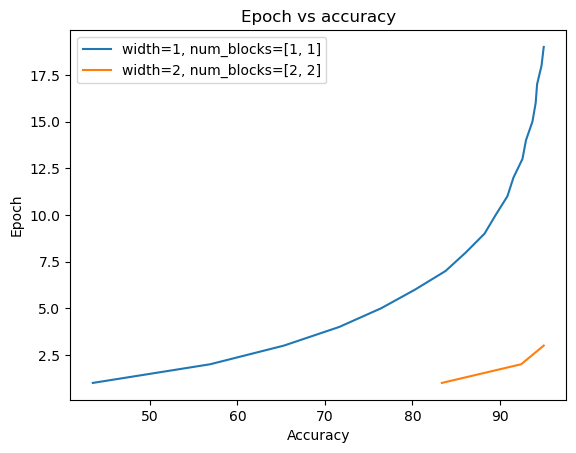

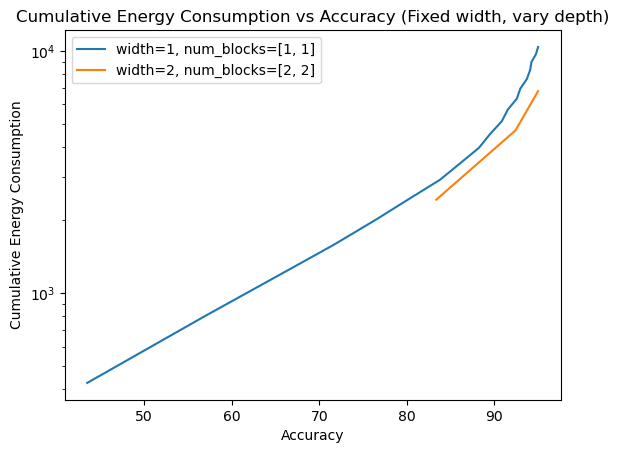

<Figure size 640x480 with 0 Axes>

Elapsed time: 1276.5174810886383 seconds


In [18]:
import torch.nn.functional as F
import torch.nn as nn
import torch
import time

class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Identity shortcut connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

        # Xavier initialization
        nn.init.xavier_uniform_(self.conv1.weight)
        nn.init.xavier_uniform_(self.conv2.weight)
        if stride != 1 or in_channels != out_channels:
            nn.init.xavier_uniform_(self.shortcut[0].weight)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, num_blocks, width_multiplication=1, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64 * width_multiplication

        self.conv1 = nn.Conv2d(1, 64 * width_multiplication, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64 * width_multiplication)
        self.layer1 = self._make_layer(64 * width_multiplication, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(128 * width_multiplication, num_blocks[1], stride=1)
        self.linear = nn.Linear(128 * width_multiplication, num_classes)

        # Xavier initialization
        nn.init.xavier_uniform_(self.conv1.weight)
        nn.init.xavier_uniform_(self.linear.weight)

    def _make_layer(self, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(BasicBlock(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)


    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = F.avg_pool2d(out, out.size()[2:])
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

    
# Reshape the images to (batch_size, 1, 28, 28)
train_imgs = train_imgs.view(-1, 1, 28, 28)
test_imgs = test_imgs.view(-1, 1, 28, 28)

# Create data loaders
batch_size = 64
train_dataset = TensorDataset(train_imgs, train_labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(test_imgs, test_labels)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


width_variations = [1, 2]
depth_variations = [[1, 1], [2, 2]]

lr=0.001
start_time = time.time()
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
# Instantiate the ResNet for each depth variation
for depth, width_mult in zip(depth_variations, width_variations):
    print(f'Training with width multiplier={width_mult}, depth={depth}')
    model = ResNet(depth, width_multiplication=width_mult)  
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    # Training
    epochs = 100
    best_accuracy = 0
    epochs_without_improvement = 0
    accuracies = []
    cumulative_energy_consumption = 0
    energy_consumptions = []
    
    for epoch in range(epochs):
        energy_consumption = 0
        for images, labels in train_loader:
            # Move images and labels to GPU if available
            images = images.to(device)
            labels = labels.to(device)
            # Clear gradients
            optimizer.zero_grad()
            # Forward propagation
            outputs = model(images)
            # Calculate loss
            loss = criterion(outputs, labels)
            # Backpropagation
            loss.backward()
            # Save the current weights
            weights_before_update = [w.clone() for w in model.parameters()]
            # Update weights
            optimizer.step()
            # Calculate the size of the weight updates using L1 norm
            weight_updates = [weights_before_update[i] - w for i, w in enumerate(model.parameters())]
            weight_update_sizes = [w.abs().sum().item() for w in weight_updates]  # L1 norm
            # Estimate the energy consumption as the sum of the weight update sizes
            energy_consumption += sum(weight_update_sizes)
        cumulative_energy_consumption += energy_consumption
        energy_consumptions.append(cumulative_energy_consumption)

        # Test
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        accuracies.append(accuracy)
        print(f'Epoch {epoch+1}, Accuracy: {accuracy}%')

        # Stop training if accuracy reaches 95%
        if accuracy >= 95:
            print(f'Stopping training after reaching {accuracy}% accuracy.')
            break

    plt.figure(1)
    plt.semilogy(accuracies, energy_consumptions, label=f'width={width_mult}, num_blocks={depth}')
    plt.xlabel('Accuracy')
    plt.ylabel('Cumulative Energy Consumption')
    plt.title('Cumulative Energy Consumption vs Accuracy (Fixed width, vary depth)')
    plt.legend()
    plt.figure(2)
    plt.plot(accuracies, range(1, len(accuracies) + 1), label=f'width={width_mult}, num_blocks={depth}')
    plt.xlabel('Accuracy')
    plt.ylabel('Epoch')
    plt.title('Epoch vs accuracy')
    plt.legend()

plt.figure(1)
plt.savefig("/Users/tim/Desktop/postgraduate/research project/STUDY/diagram/varydepth_energy_vs_accuracy.png")


plt.figure(2)
plt.savefig("/Users/tim/Desktop/postgraduate/research project/STUDY/diagram/varydepthaccuracy_over_epochs.png")
plt.show()



end_time = time.time()

elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")
